**Objective: single digit number of "mixoplankton communities" created by pairwise association among mixoplankton
species.**

Each pairwise association score depends only on that particular pair of species (variable pairs, vectors of random proportions). However, still possible that including more species than necessary will make it harder to cluster (species that are mostly similar, but diverge on their interactions with some new species).

Would it even be possible to have a "non square" association matrix, one where mixos are clustered according to their interactions with all other eukaryotes or even prokaryotes? don't see why it shouldn't be. depends on flashweave's algorithm.

### Reading and preprocessing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split, KFold
#from sklearn.tree import DecisionTreeRegressor, plot_tree
#from sklearn.ensemble import BaggingRegressor
%matplotlib inline

#start off with spearmans + hclust and just see what we get?

In [2]:
#correlation not necessary anymore? not necessary except to graph.
#still requires NaN instead of 0.

#does distance calculation fail with NaN values? yes, it just outputs nan.
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, ward, cut_tree

In [5]:
mixo_species_freqs_18Sv4 = pd.read_csv("_out_mixo_species_freqs_18Sv4.tsv", sep = "\t", index_col=0)
mixo_species_freqs_18Sv9 = pd.read_csv("_out_mixo_species_freqs_18Sv9.tsv", sep = "\t", index_col=0)

#need these to split species into groups? why not just reload pr2_taxonomies and use species to search?
pr2_taxonomies = pd.read_csv("input_data_files/pr2_version_5.0.0_taxonomy.tsv", sep = "\t")

#disregarding 18Sv4 early
#asv_taxo_mft_18Sv4 = pd.read_csv("_out_asv_taxo_mft_18Sv4.tsv", sep = "\t", index_col=0)
asv_taxo_mft_18Sv9 = pd.read_csv("_out_asv_taxo_mft_18Sv9.tsv", sep = "\t", index_col=0)

#load environment metadata, can subset samples
env_metadata_18Sv4 = pd.read_csv("_out_env_features_18Sv4.tsv", sep = "\t", index_col = 0)
env_metadata_18Sv9 = pd.read_csv("_out_env_features_18Sv9.tsv", sep = "\t", index_col = 0)

In [20]:
#subset shallow samples only
shallow_samples_18Sv4 = env_metadata_18Sv4[ env_metadata_18Sv4["Bottle_Depth"] < 30.0 ].index
mixo_species_freqs_18Sv4 = mixo_species_freqs_18Sv4.loc[shallow_samples_18Sv4]

shallow_samples_18Sv9 = env_metadata_18Sv9[ env_metadata_18Sv9["Bottle_Depth"] < 30.0 ].index
mixo_species_freqs_18Sv9 = mixo_species_freqs_18Sv9.loc[shallow_samples_18Sv9]

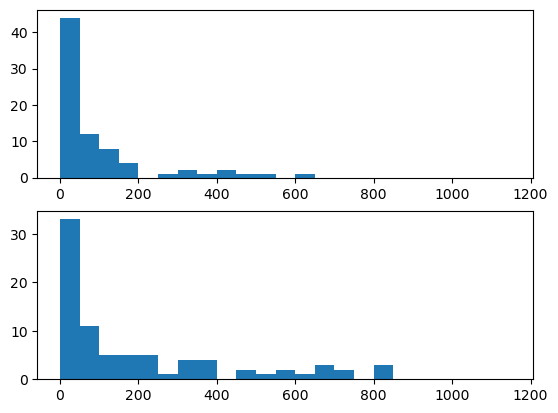

In [21]:
#numbers of nonzero values. drop any species with only 1 occurrence?
#counts of nonzero sample proportions per species
num_sample_occurrences_18Sv4 = mixo_species_freqs_18Sv4.apply(lambda col : sum(col > 0)).sort_values(ascending=False)
num_sample_occurrences_18Sv9 = mixo_species_freqs_18Sv9.apply(lambda col : sum(col > 0)).sort_values(ascending=False)

fig, ax = plt.subplots(2)
ax[0].hist(num_sample_occurrences_18Sv4, bins=range(0,1200,50))
ax[1].hist(num_sample_occurrences_18Sv9, bins=range(0,1200,50))
plt.show()

In [22]:
display(num_sample_occurrences_18Sv4.iloc[:5]),
display(num_sample_occurrences_18Sv9.iloc[:5]),

Florenciella             608
Gonyaulax_polygramma     500
Triparma_pacifica        456
Triparma_laevis_clade    448
Tripos_fusus             420
dtype: int64

Paragymnodinium_shiwhaense    826
Lepidodinium_viride           809
Karlodinium_veneficum         805
Triparma_pacifica             738
Triparma_mediterranea         734
dtype: int64

(None,)

In [23]:
def filter_data(data, num_nonzero_samples = 50, replace_zeros = True):
    #filter cols: drop all species which do not appear in sample more than 50 times. can make this more stringent
    #if it helps the correlations, and it probably will. alternately, can abandon flashweave as such, 
    #try to use MINE for mutual information
    col_mask = data.apply(lambda col : sum(col > 0) > num_nonzero_samples, axis = 0)
    
    #filter rows: drop samples where all mixos are 0? 
    #0 is not so much a 0 as a NaN. 
    #it means we haven't found any such sequences in the sample, not that they don't exist. 
    row_mask = data.apply(lambda row: sum(row > 0) > 0, axis = 1)
    
    if replace_zeros:
        return data.loc[row_mask, col_mask].replace(0,np.nan)
    return data.loc[row_mask, col_mask]


#can see if the clusters change with different cutoffs?
#it wouldn't change existing pairwise scores (distances, correlations), but might change clustering patterns.
mixo_species_freqs_18Sv4_filtered = filter_data(mixo_species_freqs_18Sv4,
                                                num_nonzero_samples=50,
                                                replace_zeros=False)
mixo_species_freqs_18Sv9_filtered = filter_data(mixo_species_freqs_18Sv9, 
                                                num_nonzero_samples=50,
                                                replace_zeros=False)

In [24]:
mixo_species_freqs_18Sv9_filtered.columns.size

49

In [25]:
pairwise_distances_18Sv4 = pdist(mixo_species_freqs_18Sv4_filtered.transpose(), metric="euclidean")
pairwise_distances_18Sv9 = pdist(mixo_species_freqs_18Sv9_filtered.transpose(), metric="euclidean")

In [26]:
squareform(pairwise_distances_18Sv4).shape

(33, 33)

In [27]:
squareform(pairwise_distances_18Sv9).shape

(49, 49)

In [28]:
#looks like it only works with euclidean?
#ward_results = linkage(mixo_species_freqs_18Sv4_filtered.transpose(), method = "ward", metric = "euclidean")
#same results as 
ward_results_18Sv4 = ward(pairwise_distances_18Sv4)
ward_results_18Sv9 = ward(pairwise_distances_18Sv9)

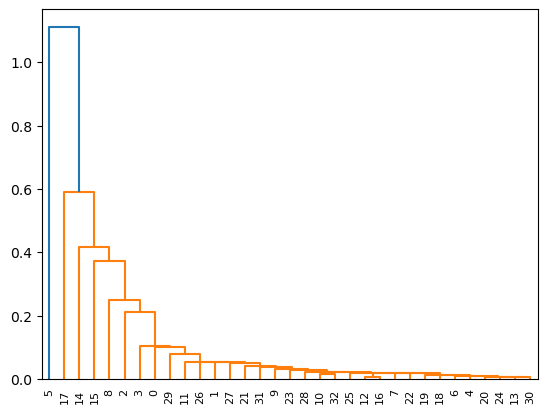

In [29]:
#not worth exploring 18Sv4 beyond this
dendrogram(ward_results_18Sv4, leaf_rotation=90)
plt.show()

In [30]:
col_array = mixo_species_freqs_18Sv9_filtered.columns.values

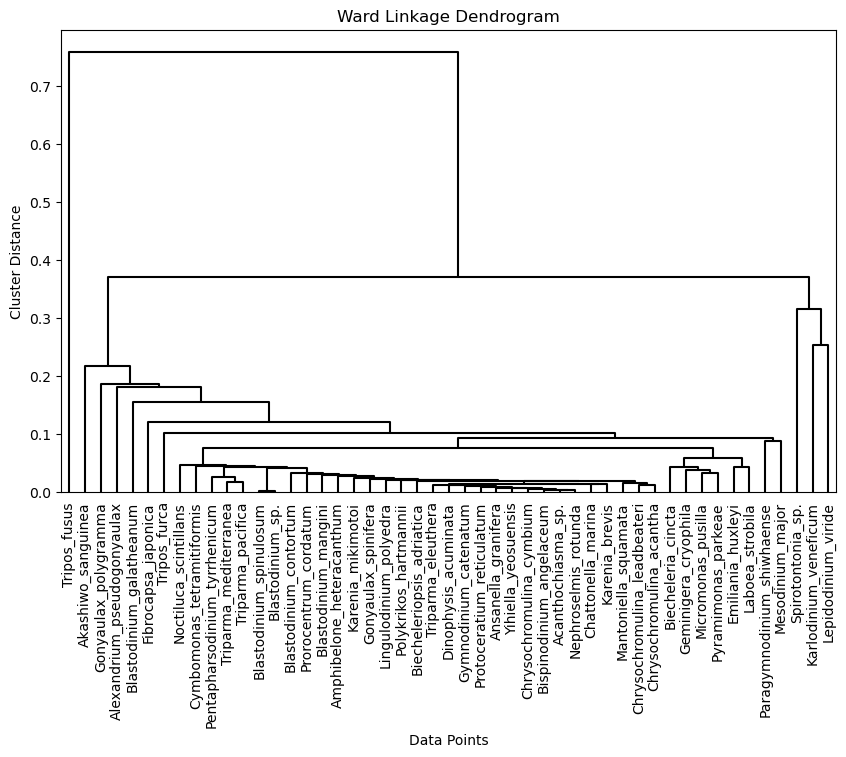

In [31]:
plt.figure(figsize=(10,6))
#link color func has to be callable
d_ward = dendrogram(ward_results_18Sv9, leaf_rotation=90, leaf_font_size=10, link_color_func=lambda x: 'black')
plt.title('Ward Linkage Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Cluster Distance')

#change x tick labels
ticks, labels = plt.xticks()
label_indices = [int(label.get_text()) for label in labels]
plt.xticks(ticks = ticks, labels = [col_array[index] for index in label_indices])
taxon_labels = [label.get_text() for label in plt.xticks()[1]] #save for later
plt.show()

In [32]:
asv_taxo_mft_18Sv9.columns
#pr2_taxonomies.loc[ pr2_taxonomies["species"] == "Collophidium_serpentinum", ["division", "subdivision", "class"] ]

Index(['Taxon', 'Confidence', 'most_specific_name', 'MFT'], dtype='object')

In [33]:
cut_tree(ward_results_18Sv9, n_clusters=15).flatten()

array([ 0,  1,  2,  3,  4,  2,  2,  2,  2,  5,  2,  2,  2,  2,  6,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  7,  2,  2,  2,  2,  2,  2,  2,  8,
        2,  2,  9, 10, 11, 11,  2,  2,  2, 12,  9, 13, 11, 11, 14])

In [34]:
#Add cluster membership to the original data
results_18Sv9 = pd.DataFrame({
    #"Species" : taxon_labels,
    "Cluster" : cut_tree(ward_results_18Sv9, n_clusters=15).flatten()
    #"Full Taxonomy" : [ for species in taxon_labels]
    
}, index = taxon_labels)
#results_18Sv9
required_cols = ["division", "subdivision", "family", "species", "mixoplankton"]
results_18Sv9_annotated = results_18Sv9.merge(pr2_taxonomies[required_cols],
                                              how = "inner", 
                                              left_index = True, 
                                              right_on = "species")
results_18Sv9_annotated.index = taxon_labels
#sort on cluster
results_18Sv9_annotated.sort_values(by="Cluster")
#results_18Sv9_annotated

,Cluster,division,subdivision,family,species,mixoplankton
Tripos_fusus,0,Alveolata,Dinoflagellata,Ceratiaceae,Tripos_fusus,CM
Akashiwo_sanguinea,1,Alveolata,Dinoflagellata,Gymnodiniaceae,Akashiwo_sanguinea,CM
Polykrikos_hartmannii,2,Alveolata,Dinoflagellata,Gymnodiniaceae,Polykrikos_hartmannii,CM
Biecheleriopsis_adriatica,2,Alveolata,Dinoflagellata,Suessiaceae,Biecheleriopsis_adriatica,CM
Triparma_eleuthera,2,Stramenopiles,Gyrista,Triparmaceae,Triparma_eleuthera,CM
Protoceratium_reticulatum,2,Alveolata,Dinoflagellata,Protoceratiaceae,Protoceratium_reticulatum,CM
Ansanella_granifera,2,Alveolata,Dinoflagellata,Suessiaceae,Ansanella_granifera,CM
Yihiella_yeosuensis,2,Alveolata,Dinoflagellata,Suessiaceae,Yihiella_yeosuensis,CM
Chrysochromulina_cymbium,2,Haptophyta,Haptophyta_X,Chrysochromulinaceae,Chrysochromulina_cymbium,CM
Bispinodinium_angelaceum,2,Alveolata,Dinoflagellata,Gymnodiniaceae,Bispinodinium_angelaceum,CM


**Correlation heatmap**

Make new dataframes, don't use the 0 ones.

In [35]:
#numbers of cells per column with r greater in magnitude than 0.4, not counting correlation of variable w/ itself
sum(abs(mixo_species_freqs_18Sv4_filtered.corr(method="spearman").values) > 0.40) - 1

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3])

In [36]:
#exclude NA/null by default.
sum(abs(mixo_species_freqs_18Sv9_filtered.corr(method="spearman").values) > 0.40) - 1

array([0, 1, 1, 3, 3, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 3, 2, 3, 0, 1, 0, 1,
       0, 0, 0, 3, 0])

In [37]:
#want to to try heatmapping and clustering these, see what happens.
mixo_species_freqs_18Sv9_filtered.corr(method="spearman") #so even correlations can be NAN. will hclust be affected?

,Paragymnodinium_shiwhaense,Gonyaulax_polygramma,Noctiluca_scintillans,Karlodinium_veneficum,Tripos_fusus,Blastodinium_mangini,Chrysochromulina_cymbium,Blastodinium_contortum,Polykrikos_hartmannii,Blastodinium_galatheanum,...,Micromonas_pusilla,Nephroselmis_rotunda,Karenia_brevis,Chrysochromulina_acantha,Tripos_furca,Laboea_strobila,Alexandrium_pseudogonyaulax,Biecheleria_cincta,Pyramimonas_parkeae,Akashiwo_sanguinea
Paragymnodinium_shiwhaense,1.000000,0.035047,0.137886,0.037683,0.023764,-0.022011,0.045807,-0.025594,0.129880,-0.077530,...,0.145225,0.067391,0.129949,0.171926,-0.060196,0.028430,0.050186,0.287580,0.200400,0.021060
Gonyaulax_polygramma,0.035047,1.000000,0.339588,0.316601,0.437357,0.193083,0.171933,0.241649,0.000568,0.061092,...,-0.090790,-0.073299,0.201263,0.071058,0.349300,0.013941,0.037609,-0.096394,-0.071471,0.123399
Noctiluca_scintillans,0.137886,0.339588,1.000000,0.071198,0.459999,0.062800,0.045659,-0.017968,0.245495,-0.047159,...,0.010787,0.088399,0.279168,0.051254,0.209055,0.087993,0.143644,0.002449,0.138993,0.092880
Karlodinium_veneficum,0.037683,0.316601,0.071198,1.000000,0.095642,0.242747,0.285198,0.287929,-0.177531,0.151739,...,-0.388464,-0.183031,-0.022347,0.174572,0.100145,-0.184481,-0.099289,0.037386,-0.372520,-0.064849
Tripos_fusus,0.023764,0.437357,0.459999,0.095642,1.000000,0.107085,0.040258,0.090862,0.201560,-0.012848,...,0.074320,0.004335,0.243173,0.110960,0.419672,0.191702,0.213686,0.021037,0.153858,0.155732
Blastodinium_mangini,-0.022011,0.193083,0.062800,0.242747,0.107085,1.000000,0.156461,0.372484,-0.086645,0.323476,...,-0.143254,-0.056884,-0.005010,0.019993,0.046206,0.011223,-0.104545,-0.069235,-0.136990,-0.100056
Chrysochromulina_cymbium,0.045807,0.171933,0.045659,0.285198,0.040258,0.156461,1.000000,0.274862,-0.097681,0.172953,...,-0.078653,-0.094502,-0.038274,0.172380,0.160214,-0.018444,-0.035659,0.021244,-0.107187,-0.093064
Blastodinium_contortum,-0.025594,0.241649,-0.017968,0.287929,0.090862,0.372484,0.274862,1.000000,-0.063468,0.295476,...,-0.129788,-0.094580,0.010626,0.130264,0.102164,-0.014038,-0.031970,0.000570,-0.118549,-0.094941
Polykrikos_hartmannii,0.129880,0.000568,0.245495,-0.177531,0.201560,-0.086645,-0.097681,-0.063468,1.000000,-0.079447,...,0.069975,0.163300,0.063726,-0.020579,0.148174,0.160489,0.213385,0.116951,0.202373,0.362114
Blastodinium_galatheanum,-0.077530,0.061092,-0.047159,0.151739,-0.012848,0.323476,0.172953,0.295476,-0.079447,1.000000,...,-0.151990,-0.064302,-0.045044,-0.031116,0.033192,0.068256,-0.099428,-0.078303,-0.127489,-0.085140


In [38]:
#don't know how flashweave would react to NAN. can try it out anyways. would rather use the filtered outfiles
#anyways compared to the nonfiltered ones.

In [39]:
assert(False)

AssertionError: 

In [ ]:
env_features_18Sv4 = pd.read_csv("_out_env_features_18Sv4.tsv", sep = "\t", index_col=0)
env_features_18Sv9 = pd.read_csv("_out_env_features_18Sv9.tsv", sep = "\t", index_col=0)
pigment_features_18Sv4 = pd.read_csv("_out_pigment_features_18Sv4.tsv", sep = "\t", index_col=0)
pigment_features_18Sv9 = pd.read_csv("_out_pigment_features_18Sv9.tsv", sep = "\t", index_col=0)
response_features_18Sv4 = pd.read_csv("_out_response_features_18Sv4.tsv", sep = "\t", index_col = 0)
response_features_18Sv9 = pd.read_csv("_out_response_features_18Sv9.tsv", sep = "\t", index_col = 0)

In [ ]:
#All expected data types: 3 non-continuous variables
response_features_18Sv4

In [ ]:
categorical_env_features = env_features_18Sv4.select_dtypes(exclude=[float]).columns.values
numerical_env_features = env_features_18Sv4.select_dtypes(include=[float]).columns.values
categorical_env_features.shape, numerical_env_features.shape, env_features_18Sv4.columns.shape

In [ ]:
season_onehot = pd.get_dummies(env_features_18Sv4["season"], prefix="season")
#nan values are not given a number
season_onehot.loc[['X201511_076.7_080.0_13', 'X201511_076.7_080.0_49',
       'X202007_090.0_090.0_10', 'X202007_090.0_090.0_75']]

In [ ]:
env_features_18Sv4.loc[[type(env_features_18Sv4.loc[index, "season"]) == float for index in env_features_18Sv4.index]].index

In [ ]:
env_features_18Sv4["season"].values.reshape(-1,1)

In [ ]:
#removes all rows with nan values, 206 rows lost
env_features_18Sv4.dropna().shape, env_features_18Sv4.shape

In [ ]:
#one hot encoder counts nan as a distinct value
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoded_sparse_matrix = encoder.fit_transform(env_features_18Sv4["season"].values.reshape(-1,1))
encoded_sparse_matrix.todense()

### Filtering rows with NA values & one-hot for categorical variables

Scikit learn's binary decision trees cannot handle missing values

In [ ]:
categorical_env_features

In [ ]:
#only removes the rows with nan values on categorical variables
env_features_18Sv4_filtered = env_features_18Sv4.dropna()
env_features_18Sv9_filtered = env_features_18Sv9.dropna()
env_features_18Sv4_filtered.shape, env_features_18Sv9_filtered.shape

In [ ]:
X_18Sv4 = env_features_18Sv4_filtered[numerical_env_features].join(
    pd.get_dummies(env_features_18Sv4_filtered["Cast_Type"], prefix="Cast_Type")).join(
    pd.get_dummies(env_features_18Sv4_filtered["Cardinal_Sta"], prefix="Cardinal")).join(
    pd.get_dummies(env_features_18Sv4_filtered["season"], prefix="season"))

X_18Sv9 = env_features_18Sv9_filtered[numerical_env_features].join(
    pd.get_dummies(env_features_18Sv9_filtered["Cast_Type"], prefix="Cast_Type")).join(
    pd.get_dummies(env_features_18Sv9_filtered["Cardinal_Sta"], prefix="Cardinal")).join(
    pd.get_dummies(env_features_18Sv9_filtered["season"], prefix="season"))

In [ ]:
X_18Sv4

In [ ]:
X_18Sv9

### Model 1: Within sample dino CM percent

per sample dino CM proportion

per sample dino CM diversity (among other dinos)

per sample CM proportion 

per sample CM diversity (among all other ASVs?)

In [ ]:
dino_CM_percent_18Sv4 = response_features_18Sv4.loc[X_18Sv4.index,"within_sample_dino_CM_percent"]
dino_CM_percent_18Sv9 = response_features_18Sv9.loc[X_18Sv9.index,"within_sample_dino_CM_percent"]

In [ ]:
dino_CM_percent_18Sv4

**Train test split**

There's 1 feature dataset and 2 response datasets, we're going to use ~20% of the features to test later
Make a selection vector and use it to make Xtrain, Xtest, y1train, y1test, y2train, y2test?

Problem! Say I make an ensemble model fitted to 80% of either response vector. If we're starting with the premise that v4 and v9 offer very different views... which one is actually correct? is the test set just going to be "every single observation twice, except associated with two different responses each time?" what would accuracy on something like that even mean?

it would be one thing to have 2 models where ASV data are predictors and something biogeochemical is the response (bowman)...

In [ ]:
X_train_18Sv4, X_test_18Sv4, y_train_18Sv4, y_test_18Sv4 = train_test_split(X_18Sv4, dino_CM_percent_18Sv4,
                                                                           test_size = 0.2, random_state = 0) 

In [ ]:
#possibilities: too many of the large percents end up in test set and train can't predict them,
#low train error & high test error
def cv(X, y, B, folds):
    cv_index = np.random.randint(0, folds, X.index.size)
    mse_per_fold = []
    for fold in range(folds):
        model = BaggingRegressor(
            base_estimator=DecisionTreeRegressor(
                #max_depth=6
            ), #see if we get better results by stopping splits earlier
            n_estimators = B, #tune this
            #oob_score=True
        ).fit(X.loc[cv_index != fold], y.loc[cv_index != fold])
        mse = np.mean(
            (model.predict(X.loc[cv_index == fold]) - y.loc[cv_index == fold]) ** 2
        )
        mse_per_fold.append(mse)
    return np.mean(mse_per_fold)

B_range = [i for i in range(15, 100)]
cv_errors = [cv(folds=10, X=X_train_18Sv4, y=y_train_18Sv4, B = B) for B in B_range]
fig, ax = plt.subplots()
ax.scatter(x=B_range, y=cv_errors)
plt.show()

In [ ]:
model_env_dino_CM_percent_18Sv4 = BaggingRegressor(
    #estimator=DecisionTreeRegressor(), #see if we get better results by stopping splits earlier
    n_estimators = 100, #tune this
    #oob_score=True,
    random_state=0
).fit(X_train_18Sv4, y_train_18Sv4)

residuals = (model_env_dino_CM_percent_18Sv4.predict(X_test_18Sv4) - y_test_18Sv4)
fig, ax = plt.subplots()
ax.hist(residuals)
plt.show()

np.mean(residuals ** 2)# ** 0.5

In [ ]:
X_train_18Sv9, X_test_18Sv9, y_train_18Sv9, y_test_18Sv9 = train_test_split(X_18Sv9, dino_CM_percent_18Sv9,
                                                                           test_size = 0.2, random_state = 0) 

In [ ]:
model_env_dino_CM_percent_18Sv9 = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=6), #see if we get better results by stopping splits earlier
    n_estimators = 20, #tune this
    #oob_score=True,
    random_state=0
).fit(X_train_18Sv9, y_train_18Sv9)
np.mean((model_env_dino_CM_percent_18Sv9.predict(X_test_18Sv9) - y_test_18Sv9) ** 2)# ** 0.5

y_pred_18Sv9 = model_env_dino_CM_percent_18Sv4.predict(X_test_18Sv9)
residuals = (y_test_18Sv9 - y_pred_18Sv9)
fig, ax = plt.subplots()
ax.hist(residuals, bins=np.arange(-20,20,0.5))
plt.show()

np.mean(residuals ** 2), np.min(y_pred_18Sv9) #wouldn't expect to go below 0

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(model_env_dino_CM_percent_18Sv9.estimators_[3],feature_names=X_train_18Sv9.columns, fontsize=8)
plt.show()

In [ ]:
#need a way to access every tree and every split, and count the involvement of each feature
#we can see that every estimator was working from the same set of features
model_env_dino_CM_percent_18Sv9.estimators_features_

In [ ]:
for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    #binary tree stored as parallel arrays, each array holds info about ith node (internal or leaf)
    tree = estimator.tree_
    print(tree)
    #every -2 represents a leaf node
    #print(tree.feature)
    #mse is the impurity measure for regression
    #print(tree.impurity)

#a good split will decrease the amount of impurity? not necessarily. might split into a large low mse node
#and a small, high mse node. so they have to be weighted?
#MSE decrease = MSE_parent - sum(MSE_children)
#does not need to be calculated when "MSE parent" would be a leaf node.

In [ ]:
total_se_decrease=[0] * X_train_18Sv4.columns.size

for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    tree = estimator.tree_
    for node_id in range(len(tree.feature)):
        #if this node is a leaf, skip
        feature_id = tree.feature[node_id]
        if feature_id < 0:
            continue
        #if node is not a leaf, find MSE_parent - sum(MSE_children)
        left_child_id = tree.children_left[node_id]
        right_child_id = tree.children_right[node_id]
        SE_parent = tree.impurity[node_id] * tree.n_node_samples[node_id]
        SE_children = (tree.impurity[left_child_id] * tree.n_node_samples[left_child_id]) \
                    + (tree.impurity[right_child_id] * tree.n_node_samples[right_child_id])
        #seems like we can't count on this, a split will choose a bad option even if it's "best"
        #assert(SE_parent >= SE_children)
        #if SE_parent < SE_children:
        #    print(SE_parent, tree.impurity[node_id], tree.n_node_samples[node_id])
        #    print(SE_children, tree.impurity[left_child_id], tree.n_node_samples[left_child_id])
        #    print(tree.impurity[right_child_id], tree.n_node_samples[right_child_id])
        #    print(tree)
        #    assert(False)
        #attribute the MSE decrease to the feature that this node splits on
        total_se_decrease[feature_id] += (SE_parent - SE_children)
        
pd.Series(total_se_decrease, index=X_train_18Sv9.columns).sort_values(ascending=False)